In [1]:
# Step 1: Install the Kaggle API
!pip install kaggle

# Step 2: Upload your Kaggle API key
from google.colab import files
files.upload()

# Step 3: Move the Kaggle API key to the correct location
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Step 4: Download the dataset from Kaggle
!kaggle datasets download -d mehradaria/leukemia

# Step 5: Extract the dataset
!unzip leukemia.zip -d /content/dataset

# Step 6: List the contents of the dataset directory to verify the structure
!ls /content/dataset

# If necessary, list the contents of the subdirectories
!ls /content/dataset/*

# Now that we know the structure, update the paths accordingly
original_dir = '/content/dataset/Original'
segmented_dir = '/content/dataset/Segmented'

# Verify that the paths exist and are correct
print("Original Directory:", original_dir)
print("Segmented Directory:", segmented_dir)
!ls {original_dir}
!ls {segmented_dir}

import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.utils import to_categorical, Sequence
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, Callback
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Activation, MaxPooling2D, Conv2DTranspose
import tensorflow.keras.backend as K

# Custom callback to print accuracy and loss after each epoch
class PrintEpochResults(Callback):
    def __init__(self, print_frequency=5):
        super(PrintEpochResults, self).__init__()
        self.print_frequency = print_frequency

    def on_epoch_end(self, epoch, logs=None):
        if (epoch + 1) % self.print_frequency == 0:
            print(f"Epoch {epoch + 1}:")
            print(f"  Train Accuracy: {logs['accuracy']:.4f}")
            print(f"  Validation Accuracy: {logs['val_accuracy']:.4f}")
            print(f"  Train Loss: {logs['loss']:.4f}")
            print(f"  Validation Loss: {logs['val_loss']:.4f}")

# Data generator class
class DataGenerator(Sequence):
    def __init__(self, image_paths, mask_paths, batch_size=16, image_size=(256, 256), num_classes=2, shuffle=True, **kwargs):
        super().__init__(**kwargs)
        self.image_paths = image_paths
        self.mask_paths = mask_paths
        self.batch_size = batch_size
        self.image_size = image_size
        self.num_classes = num_classes
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        return len(self.image_paths) // self.batch_size

    def __getitem__(self, index):
        batch_indices = self.indices[index*self.batch_size:(index+1)*self.batch_size]
        batch_image_paths = [self.image_paths[i] for i in batch_indices]
        batch_mask_paths = [self.mask_paths[i] for i in batch_indices]

        images, masks = self.__load_data(batch_image_paths, batch_mask_paths)
        return images, masks

    def on_epoch_end(self):
        self.indices = np.arange(len(self.image_paths))
        if self.shuffle:
            np.random.shuffle(self.indices)

    def __load_data(self, image_paths, mask_paths):
        images = []
        masks = []
        for img_path, mask_path in zip(image_paths, mask_paths):
            img = cv2.imread(img_path)
            mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
            if img is not None and mask is not None:
                img = cv2.resize(img, self.image_size)
                mask = cv2.resize(mask, self.image_size)
                img = img / 255.0
                mask = (mask > 0).astype(int)
                images.append(img)
                masks.append(mask)
        images = np.array(images)
        masks = np.array(masks)
        masks = to_categorical(masks, num_classes=self.num_classes)
        return images, masks

def get_image_mask_paths(data_dir, mask_dir):
    image_paths = []
    mask_paths = []
    categories = ['Pro', 'Pre', 'Early', 'Benign']
    for category in categories:
        cat_image_dir = os.path.join(data_dir, category)
        cat_mask_dir = os.path.join(mask_dir, category)
        for filename in os.listdir(cat_image_dir):
            if filename.endswith(".jpg"):
                img_path = os.path.join(cat_image_dir, filename)
                mask_path = os.path.join(cat_mask_dir, filename)  # Mask has the same filename as the image
                if os.path.exists(mask_path):  # Ensure corresponding mask exists
                    image_paths.append(img_path)
                    mask_paths.append(mask_path)
    return image_paths, mask_paths

def compute_class_weights(masks):
    labels = masks.flatten()
    classes = np.unique(labels)
    weights = compute_class_weight('balanced', classes=classes, y=labels)
    return {i: weights[i] for i in range(len(classes))}

def weighted_categorical_crossentropy(weights):
    weights = K.variable(weights)
    def loss(y_true, y_pred):
        y_true = K.cast(y_true, y_pred.dtype)
        y_true = K.flatten(y_true)
        y_pred = K.flatten(y_pred)
        return K.categorical_crossentropy(y_true, y_pred) * weights
    return loss

# Paths to data directories
image_paths, mask_paths = get_image_mask_paths(original_dir, segmented_dir)

# Split data
train_image_paths, val_image_paths, train_mask_paths, val_mask_paths = train_test_split(image_paths, mask_paths, test_size=0.2, random_state=42)

# Compute class weights based on the first few batches
train_gen_for_weights = DataGenerator(train_image_paths[:256], train_mask_paths[:256], batch_size=256)
train_images_sample, train_masks_sample = train_gen_for_weights.__getitem__(0)
class_weights = compute_class_weights(train_masks_sample.argmax(axis=-1))

# Convert class weights to array
class_weights_array = np.array(list(class_weights.values()))

# Data generators
train_gen = DataGenerator(train_image_paths, train_mask_paths, batch_size=16)
val_gen = DataGenerator(val_image_paths, val_mask_paths, batch_size=16)

def build_segnet(input_shape, num_classes):
    inputs = Input(shape=input_shape)

    # Encoder
    x = Conv2D(64, (3, 3), padding='same')(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D((2, 2))(x)

    x = Conv2D(128, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D((2, 2))(x)

    x = Conv2D(256, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D((2, 2))(x)

    # Decoder
    x = Conv2DTranspose(256, (3, 3), strides=(2, 2), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2DTranspose(128, (3, 3), strides=(2, 2), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2DTranspose(64, (3, 3), strides=(2, 2), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    outputs = Conv2D(num_classes, (1, 1), activation='softmax')(x)

    model = Model(inputs=[inputs], outputs=[outputs])
    return model

# Build the model and compile with custom loss
model = build_segnet((256, 256, 3), 2)
model.compile(optimizer=Adam(), loss=weighted_categorical_crossentropy(class_weights_array), metrics=['accuracy'])

# Change file extension to `.keras`
callbacks = [
    ModelCheckpoint('best_model_segnet.keras', save_best_only=True),
    EarlyStopping(patience=10),
    ReduceLROnPlateau(factor=0.1, patience=5),
    PrintEpochResults(print_frequency=5)
]
history = model.fit(train_gen, validation_data=val_gen, epochs=50, callbacks=callbacks)
print("Train Accuracy:", history.history['accuracy'][-1])
print("Validation Accuracy:", history.history['val_accuracy'][-1])



Streaming output truncated to the last 5000 lines.
  inflating: /content/dataset/Original/Pre/WBC-Malignant-Pre-037.jpg  
  inflating: /content/dataset/Original/Pre/WBC-Malignant-Pre-038.jpg  
  inflating: /content/dataset/Original/Pre/WBC-Malignant-Pre-039.jpg  
  inflating: /content/dataset/Original/Pre/WBC-Malignant-Pre-040.jpg  
  inflating: /content/dataset/Original/Pre/WBC-Malignant-Pre-041.jpg  
  inflating: /content/dataset/Original/Pre/WBC-Malignant-Pre-042.jpg  
  inflating: /content/dataset/Original/Pre/WBC-Malignant-Pre-043.jpg  
  inflating: /content/dataset/Original/Pre/WBC-Malignant-Pre-044.jpg  
  inflating: /content/dataset/Original/Pre/WBC-Malignant-Pre-045.jpg  
  inflating: /content/dataset/Original/Pre/WBC-Malignant-Pre-046.jpg  
  inflating: /content/dataset/Original/Pre/WBC-Malignant-Pre-047.jpg  
  inflating: /content/dataset/Original/Pre/WBC-Malignant-Pre-048.jpg  
  inflating: /content/dataset/Original/Pre/WBC-Malignant-Pre-049.jpg  
  inflating: /content/data

162/162 [==============================] - 60s 259ms/step - loss: 21922292.0000 - accuracy: 0.8887 - val_loss: 22203074.0000 - val_accuracy: 0.8012 - lr: 0.0010
Epoch 2/50
162/162 [==============================] - 45s 275ms/step - loss: 21867472.0000 - accuracy: 0.8992 - val_loss: 22082572.0000 - val_accuracy: 0.8332 - lr: 0.0010
Epoch 3/50
162/162 [==============================] - 44s 271ms/step - loss: 21857920.0000 - accuracy: 0.9018 - val_loss: 21895526.0000 - val_accuracy: 0.8928 - lr: 0.0010
Epoch 4/50
162/162 [==============================] - 45s 276ms/step - loss: 21855068.0000 - accuracy: 0.9023 - val_loss: 21871398.0000 - val_accuracy: 0.8997 - lr: 0.0010
Epoch 5/50
162/162 [==============================] - ETA: 0s - loss: 21849264.0000 - accuracy: 0.9038Epoch 5:
  Train Accuracy: 0.9038
  Validation Accuracy: 0.9016
  Train Loss: 21849264.0000
  Validation Loss: 21869342.0000
162/162 [==============================] - 45s 276ms/step - loss: 21849264.0000 - accuracy: 0.90

In [6]:
print("Train Accuracy:", history.history['accuracy'][-1])
print("Validation Accuracy:", history.history['val_accuracy'][-1])

best_model = tf.keras.models.load_model('best_model_segnet.keras', custom_objects={'loss': weighted_categorical_crossentropy(class_weights_array)})
test_loss, test_accuracy = best_model.evaluate(val_gen)
print("Test Accuracy:", test_accuracy)


Train Accuracy: 0.9085109233856201
Validation Accuracy: 0.912527859210968
40/40 [==============================] - 4s 91ms/step - loss: 21817886.0000 - accuracy: 0.9128
Test Accuracy: 0.9127640724182129


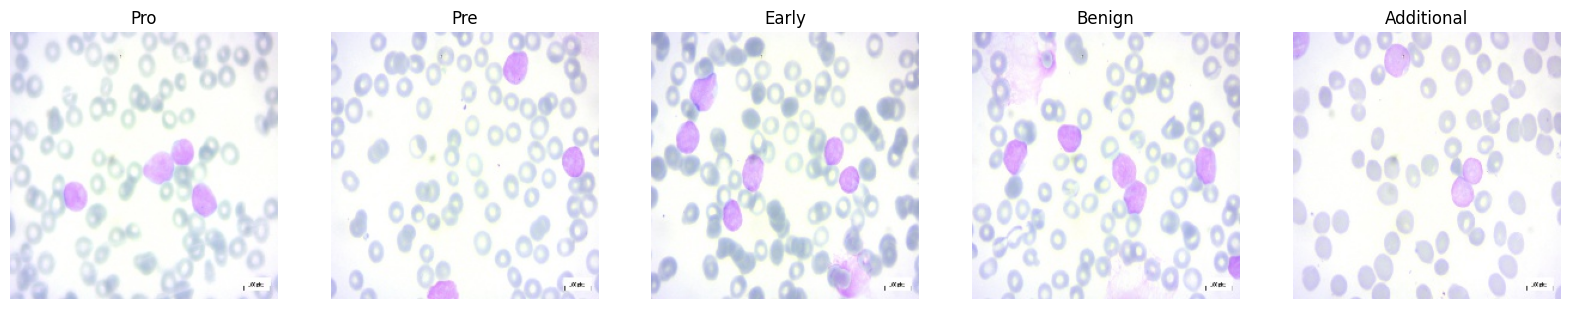

In [3]:
import matplotlib.pyplot as plt
import cv2
import os

def load_images(image_paths):
    images = []
    for img_path in image_paths[:5]:  # Load only the first 5 images for display
        img = cv2.imread(img_path)
        if img is not None:
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB for display
            images.append(img)
    return images

def display_images(images, titles=None):
    fig, axes = plt.subplots(1, len(images), figsize=(20, 5))
    for i, (img, ax) in enumerate(zip(images, axes)):
        ax.imshow(img)
        if titles is not None:
            ax.set_title(titles[i])
        ax.axis('off')  # Hide axes
    plt.show()

# Assuming you have already loaded image paths
original_dir = '/content/dataset/Original'
categories = ['Pro', 'Pre', 'Early', 'Benign']

# Collect the first image from each category to display
image_paths = []
for category in categories:
    cat_image_dir = os.path.join(original_dir, category)
    for filename in os.listdir(cat_image_dir):
        if filename.endswith(".jpg"):
            img_path = os.path.join(cat_image_dir, filename)
            image_paths.append(img_path)
            if len(image_paths) >= 5:  # Stop after collecting 5 images
                break

# Load and display images
images = load_images(image_paths)
display_images(images, titles=['Pro', 'Pre', 'Early', 'Benign', 'Additional'])

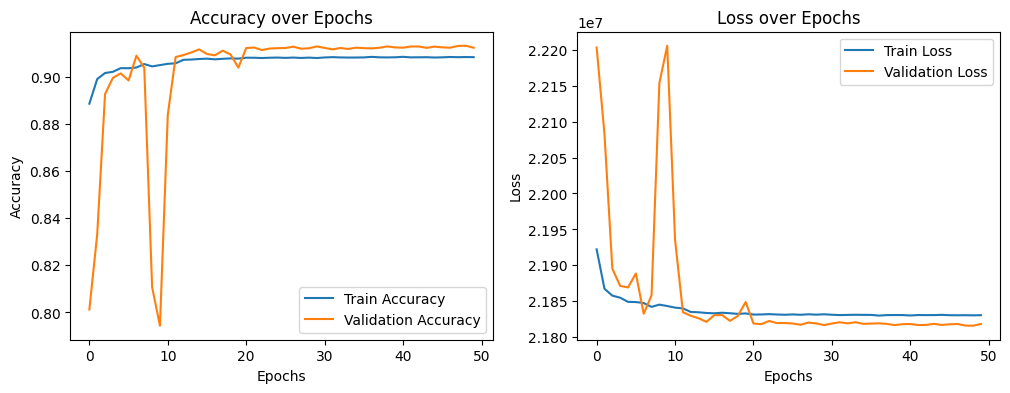

In [4]:
# Plotting the training and validation accuracy and loss
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy over Epochs')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss over Epochs')

plt.show()


In [5]:
import pandas as pd
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report

val_preds = best_model.predict(val_gen)
val_preds_classes = np.argmax(val_preds, axis=-1)
val_true_classes = np.argmax(np.concatenate([y for x, y in val_gen], axis=0), axis=-1)

# Print classification report
report = classification_report(val_true_classes.flatten(), val_preds_classes.flatten(), target_names=['Benign', 'Malignant'])
print(report)

40/40 [==============================] - 8s 163ms/step
              precision    recall  f1-score   support

      Benign       0.80      0.85      0.82  33552552
   Malignant       0.21      0.16      0.18   8390488

    accuracy                           0.71  41943040
   macro avg       0.51      0.50      0.50  41943040
weighted avg       0.68      0.71      0.70  41943040

